# Assignment 5
## Matthew Kenneth Peterson (3719754)
## Jake van der Laan
## CS 4403
## March 28th, 2025

In [10]:
import os
import random
import re
from random import shuffle
from unittest import case

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from IPython.core.pylabtools import figsize
from colorama import Fore, Back, Style

In [11]:
dataframes = {
	2018 : pd.read_parquet("../data/clean_joined_2018.parquet"),
	2019 : pd.read_parquet("../data/clean_joined_2019.parquet"),
	2020 : pd.read_parquet("../data/clean_joined_2020.parquet"),
	2021 : pd.read_parquet("../data/clean_joined_2021.parquet"),
	2022 : pd.read_parquet("../data/clean_joined_2022.parquet"),
}

In [12]:
# Create a mapping dictionary for manufacturer names
manufacturer_mapping = {
    'AIRBUS.*': 'AIRBUS',  # Will match any variation starting with AIRBUS
    'BOEING.*': 'BOEING',
	'MCDONNELL DOUGLAS.*': 'MCDONNELL DOUGLAS',
    'LOCKHEED.*': 'LOCKHEED MARTIN',
    'EMBRAER.*': 'EMBRAER',
	'SAAB.*': 'SAAB',
	'DIAMOND AIRCRAFT.*': 'DIAMOND AIRCRAFT',
	'ROBINSON.*': 'ROBINSON',
	'AIR TRACTOR.*': 'AIR TRACTOR',
}

# Function to standardize manufacturer names
def standardize_manufacturer(name : str) -> str:
    for pattern, standard_name in manufacturer_mapping.items():
        if pd.notna(name) and re.match(pattern, name, flags=re.IGNORECASE):
            return standard_name
    return name.strip()  # Return original if no match

## Interesting Features
1. Delays by Manufacturer (Pie chart)
2.

## 1. Stackplots: Delays, Cancellations and Total Flights by Manufacturer

In [13]:
PRINT_SEPARATE = Fore.LIGHTYELLOW_EX
PRINT_COMBINED = Fore.CYAN
PRINT_RESET = Style.RESET_ALL

%matplotlib inline


stack_plot_data_delayed = {}
stack_plot_cancelled = {}
stack_plot_data_total = {}

for year in dataframes.keys():
	df = dataframes[year].copy()
	df_mfrs = df['MFR'].unique().tolist()

	df_combined = dataframes[year].copy()
	df_combined['MFR'] = df_combined['MFR'].apply(standardize_manufacturer)
	df_combined_mfrs = df_combined['MFR'].unique().tolist()

	def print_colouring(_df_type):
		match _df_type:
			case 'df': print(PRINT_SEPARATE, end="")
			case 'df_combined': print(PRINT_COMBINED, end="")
			case _: print(PRINT_RESET, end="")


	for df_type in ['df', 'df_combined']:
		print_colouring(df_type)

		# I'm sorry, I just really like SQL. Luckily, DuckDB
		# is efficient, and can address pandas dataframes.
		df_summed = duckdb.query(f"""
			SELECT MFR,
			SUM(CASE WHEN ArrDelayMinutes > 0 THEN 1 ELSE 0 END) AS delayed,
			SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancelled,
			SUM(CASE WHEN MFR = MFR THEN 1 ELSE 0 END) AS total,
			delayed / total AS percentage,
			FROM {df_type}
			GROUP BY MFR
			ORDER BY percentage DESC
		""").df()

		#print(df_summed)

		if df_type == 'df_combined':
			for i, row in df_summed.iterrows():
				for dictionaries in [(stack_plot_data_delayed, 'delayed'), (stack_plot_cancelled, 'cancelled'), (stack_plot_data_total, 'total')]:
					if row['total'] < 5000:
						if 'OTHER' not in dictionaries[0].keys():
							dictionaries[0]['OTHER'] = {2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0}
							
						dictionaries[0]['OTHER'][year] += row[dictionaries[1]]
	
					else:
						if row['MFR'] not in dictionaries[0].keys():
							dictionaries[0][row['MFR']] = {2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0}
							
						dictionaries[0][row['MFR']][year] += row[dictionaries[1]]

		#df_pie_chart = duckdb.query(f"""
		#	SELECT * FROM df_summed WHERE total > 5000 ORDER BY percentage DESC LIMIT 5
		#""").df()
		##print(df_pie_chart)

		print_colouring("")



 Exported all graphs to SVG. 


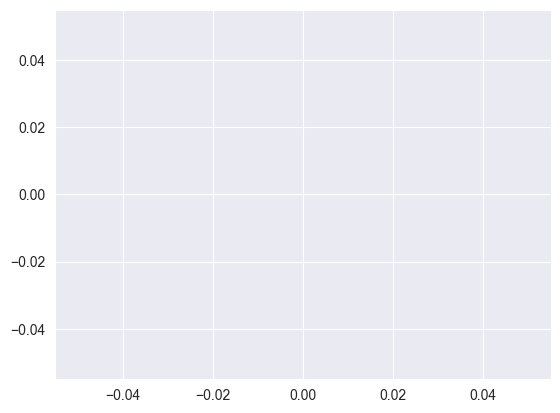

In [26]:
%matplotlib inline

stack_plot_data_wrapper = {
	"All Delays" : stack_plot_data_delayed,
	"All Cancellations" : stack_plot_cancelled,
	"All Flights" : stack_plot_data_total
}

__colours = [
	[random.random(), random.random(), random.random()]
	for _ in range(len(stack_plot_data_delayed.keys()))
]
# print(__colours)

for label, stack_data in stack_plot_data_wrapper.items():
	stack_data = dict(sorted(stack_data.items()))
	#print(stack_data)
	
	idxes = [2018, 2019, 2020, 2021, 2022]
	data = pd.DataFrame.from_dict(stack_data, orient='index')
	#print(data)
	
	i = 0
	for mfr, row in data.iterrows():
		plt.plot([], [], color=__colours[i], label=str(mfr))
		i += 1
	
	__data = [row.values.tolist() for _, row in data.iterrows()]
	#print(__data)
	
	# Use a context manager to temporarily set rcParams
	with plt.rc_context({'font.size': 140}):
		px = 1/plt.rcParams['figure.dpi']  # pixel in inches
		plt.subplots(figsize=(20000*px, 16000*px))
		plt.stackplot(np.asarray(idxes, int), __data, colors=__colours)
		plt.title(f'{label} Stack Plot')
		plt.legend(stack_data.keys(), fontsize="x-large")
		plt.xticks(idxes)
		plt.savefig(fname=f"stackplot_{label}.svg")
		
		# free memory
		plt.clf()
		plt.close()
	
	
print(Fore.GREEN, "Exported all graphs to SVG.", Fore.RESET)

## 2. 3D Scatter Plot of Aircraft Characteristics

In [15]:
%matplotlib notebook

In [16]:
import matplotlib
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d
from matplotlib.widgets import CheckButtons

faa_dataframes = {
		#2018 : pd.read_parquet("./data/faa_2018.parquet"),
		#2019 : pd.read_parquet("./data/faa_2019.parquet"),
		#2020 : pd.read_parquet("./data/faa_2020.parquet"),
		#2021 : pd.read_parquet("./data/faa_2021.parquet"),
		2022 : pd.read_parquet("../data/faa_2022.parquet"),
}

for year, faa in faa_dataframes.items():
	faa['MFR'] = faa['MFR'].apply(standardize_manufacturer)
	
	faa = faa.sort_values('MFR')
	print(faa.head())
	
	faa_trimmed = duckdb.query(f"""
		SELECT *
		FROM faa
		WHERE MFR IN (
			SELECT MFR
			FROM faa
			WHERE MFR NOT IN ('CESSNA', 'PIPER', 'BEECH')
			GROUP BY MFR
			HAVING COUNT(*) > 1000
		) AND "YEAR MFR" > 1900 AND "NO-ENG" < 12;
	""").df()
	faa_trimmed = faa_trimmed.sort_values('MFR')
	print(faa_trimmed)
	faa = faa_trimmed
	
	with plt.rc_context():
		"""
		# Create a 3D plot
		fig = plt.figure(figsize=(12, 8))
		ax = fig.add_subplot(111, projection='3d')
		
		# Create color mapping for manufacturers
		unique_mfrs = faa['MFR'].unique()
		colors = plt.cm.get_cmap('tab20', len(unique_mfrs))  # Using a qualitative colormap
		
		# Plot each manufacturer's data points
		for i, mfr in enumerate(unique_mfrs):
			mask = faa['MFR'] == mfr
			ax.scatter(
				faa.loc[mask, 'NO-ENG'],       # X-axis: Number of engines
				faa.loc[mask, 'NO-SEATS'],     # Y-axis: Number of seats
				faa.loc[mask, 'YEAR MFR'],     # Z-axis: Year manufactured
				color=colors(i),
				label=mfr,
				s=40,         # Marker size
				alpha=0.7,     # Slight transparency
				edgecolors='w' # White edges for better visibility
			)
		
		# Add labels and title
		ax.set_xlabel('Number of Engines (NO-ENG)', labelpad=12)
		ax.set_ylabel('Number of Seats (NO-SEATS)', labelpad=12)
		ax.set_zlabel('Year Manufactured (YEAR MFR)', labelpad=12)
		ax.set_title('Aircraft Manufacturer 3D Analysis', pad=20)
		
		# Add legend outside the plot
		plt.legend(
			title='Manufacturers',
			bbox_to_anchor=(1.05, 1), 
			loc='upper left',
			borderaxespad=0.
		)
		
		# Adjust layout to prevent legend cutoff
		plt.tight_layout()
		
		# Show plot
		plt.show()
		"""
				
		# Assuming your DataFrame is named 'df'
		fig = plt.figure(figsize=(14, 10))
		ax = fig.add_subplot(111, projection='3d')
		plt.subplots_adjust(left=0.25, right=0.7)  # Make space for both side panels
		
		# Create color mapping and store scatter plots
		unique_mfrs = faa['MFR'].unique()
		colors = plt.cm.get_cmap('tab20', len(unique_mfrs))
		scatters = []
		legend_elements = []
		
		# Create initial plot with all manufacturers visible
		for i, mfr in enumerate(unique_mfrs):
			mask = faa['MFR'] == mfr
			scatter = ax.scatter(
				faa.loc[mask, 'NO-ENG'],
				faa.loc[mask, 'NO-SEATS'],
				faa.loc[mask, 'YEAR MFR'],
				color=colors(i),
				label=mfr,
				s=60,
				alpha=0.7,
				edgecolors='w',
				visible=True
			)
			scatters.append(scatter)
			legend_elements.append(
				plt.Line2D([0], [0], 
					marker='o',
					color='w',
					markerfacecolor=colors(i),
					markersize=10,
					label=mfr
			   	)
			)
		
		# Axis labels and title
		ax.set_xlabel('Number of Engines (NO-ENG)', labelpad=12)
		ax.set_ylabel('Number of Seats (NO-SEATS)', labelpad=12)
		ax.set_zlabel('Year Manufactured (YEAR MFR)', labelpad=12)
		ax.set_title('Aircraft Manufacturer Build Trends by Year', pad=20)
		
		# Create checkboxes on the right side
		rax = plt.axes([0.75, 0.3, 0.2, 0.4])  # Right side position
		check_labels = [mfr for mfr in unique_mfrs]
		visibility = [scatter.get_visible() for scatter in scatters]
		check = CheckButtons(rax, check_labels, visibility)
		
		# Create color legend on the left side
		leg = ax.legend(
			handles=legend_elements,
			title='Manufacturers',
			bbox_to_anchor=(0.05, 0.8),  # Left side position
			loc='upper right',
			borderaxespad=0.,
			frameon=True
		)
		
		# Make legend interactive
		def on_legend_click(event):
			if event.artist in leg.legendHandles:
				index = leg.legendHandles.index(event.artist)
				scatters[index].set_visible(not scatters[index].get_visible())
				check.set_active(index, not check.get_status()[index])
				plt.draw()
		
		fig.canvas.mpl_connect('pick_event', on_legend_click)
		leg.set_picker(5)
		
		# Checkbox callback remains the same
		def toggle_manufacturers(_label):
			index = check_labels.index(_label)
			scatters[index].set_visible(not scatters[index].get_visible())
			plt.draw()
		
		check.on_clicked(toggle_manufacturers)
		
		# Optional performance improvements
		plt.rcParams['legend.markerscale'] = 1.5
		ax.set_box_aspect([1, 1, 1])
		
		plt.show()

       N-NUMBER                   MFR  YEAR MFR  SPEED  TYPE-ACFT  NO-SEATS  \
641       1014Z  101 FLYING ASSOC INC    1970.0     97        4.0         2   
13924     131MH             131MH LLC    2016.0      0        4.0         2   
28858     177MF             177MF LLC    2009.0      0        4.0         2   
106045    4012B            1CA-BRASOV    1978.0      0        1.0         2   
258720    9023B            1CA-BRASOV    1978.0      0        1.0         2   

        NO-ENG   AGE  
641          1  52.0  
13924        1   6.0  
28858        1  13.0  
106045       1  44.0  
258720       1  44.0  
      N-NUMBER                   MFR  YEAR MFR  SPEED  TYPE-ACFT  NO-SEATS  \
12701    9331E               AERONCA    1946.0     75        4.0         2   
13022    85889               AERONCA    1946.0     75        4.0         2   
13023    48808               AERONCA    1942.0     71        4.0         2   
13024    86195               AERONCA    1946.0     75        4.0         2 

<IPython.core.display.Javascript object>

/var/folders/cz/tk27x0h96ng469lbjl14wxkw0000gn/T/ipykernel_41034/514129277.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_mfrs))


## 3. Correlation Between Month of Flight and Delays

In [17]:
for _year, _df in dataframes.items():
	_df['Year'] = _year

df_all = pd.concat(dataframes.values())
df_all['MFR'] = df_all['MFR'].apply(standardize_manufacturer)

In [18]:
df_all_grouped = duckdb.query(f"""
	SELECT 
		(CASE WHEN x.total < 1000 THEN 'OTHER' ELSE x.MFR END) as MFR_G, 
		"Year", 
		"Month", 
		SUM(delayed) as delayed, 
		SUM(cancelled) as cancelled, 
		SUM(total) as total
	FROM (
		SELECT MFR, "Year", "Month",
		SUM(CASE WHEN ArrDelayMinutes > 0 THEN 1 ELSE 0 END) AS delayed,
		SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancelled,
		SUM(CASE WHEN MFR = MFR THEN 1 ELSE 0 END) AS total,
		FROM df_all
		GROUP BY MFR, "Year", "Month"
		ORDER BY "Year", "Month", "MFR" ASC
	) AS x
	GROUP BY MFR_G, "Year", "Month"
	ORDER BY "Year", "Month", "MFR_G" ASC
""").df()

df_all_grouped

BinderException: Binder Error: Referenced column "Month" not found in FROM clause!
Candidate bindings: "MFR"

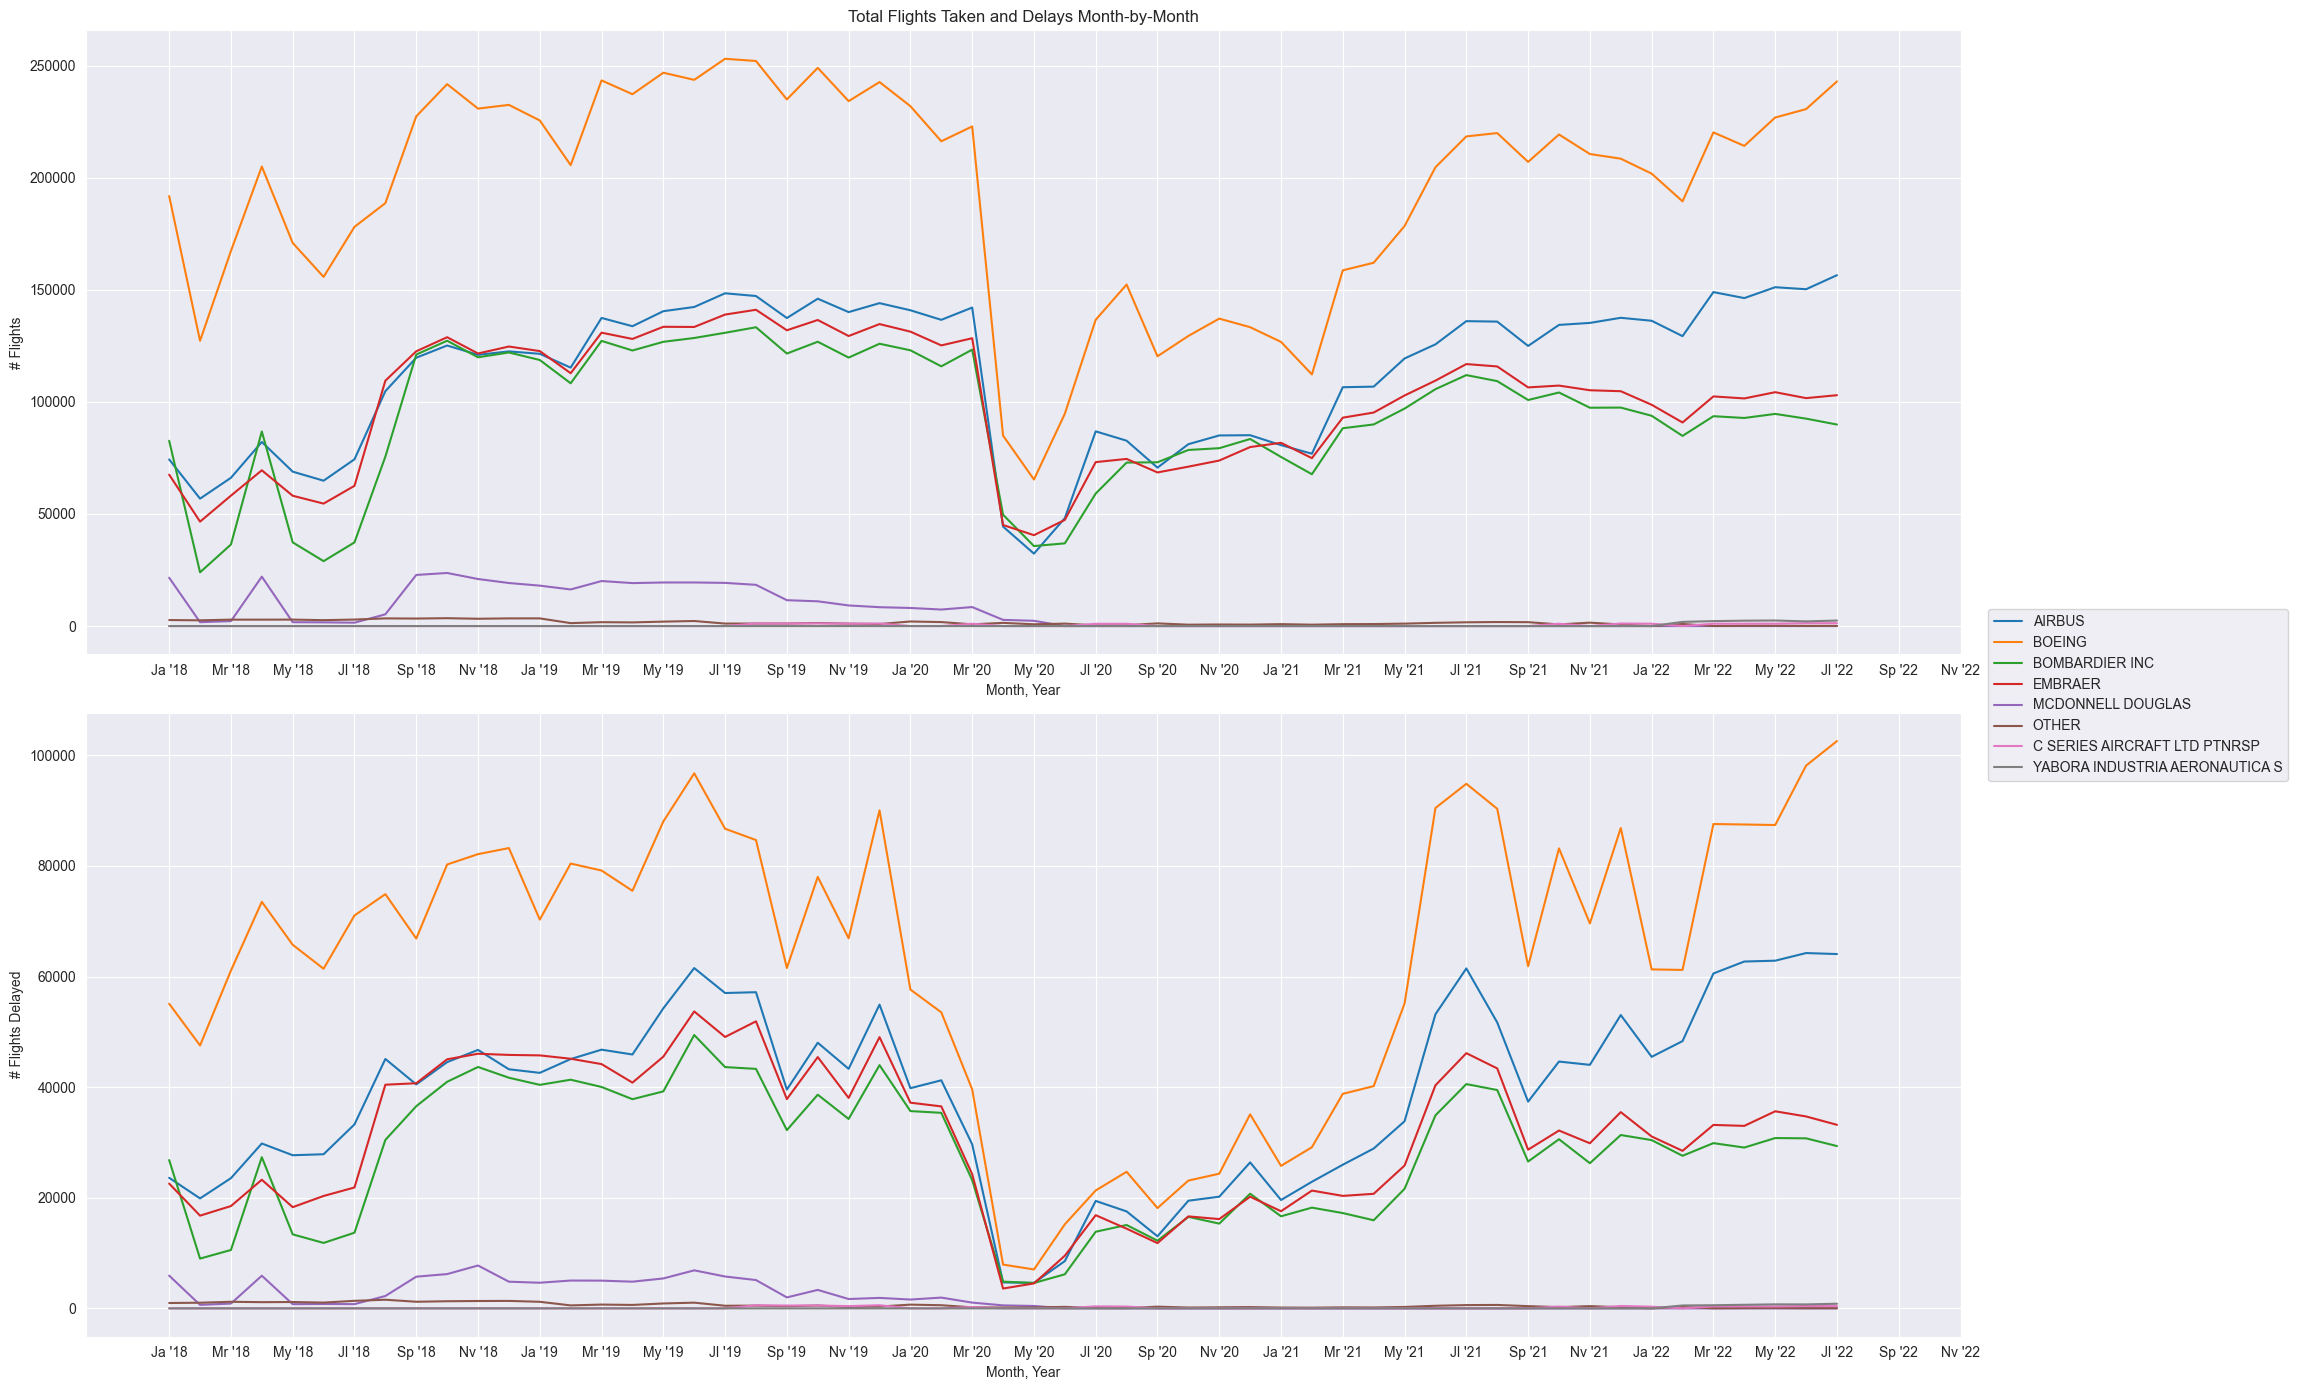

In [143]:
%matplotlib inline

from math import *

plt.clf()
plt.close()

with plt.rc_context():
	fig, axs = plt.subplots(2, figsize=(20,14))
	
	x = list(range(5 * 12))[:-5]
	#print(x)
	
	for mfr in df_all_grouped['MFR_G'].unique():
		y = duckdb.query(f"""
			SELECT * FROM df_all_grouped WHERE MFR_G == '{mfr}'
		""").df()
		
		if len(x) != len(y):
			for i in x:
				__month = 1 + i % 12
				__year = 2018 + i // 12
				if y.query('Year == @__year and Month == @__month').shape[0] == 0:
					y.loc[-i] = [mfr, __year, __month, 0, 0, 0] 
			
				y = y.sort_values(["Year", "Month"], ascending=[True, True])
		
		
		#print(mfr, len(x), len(y))
		#print(y)
		
		axs[0].plot(x, y['total'], label=mfr)
		axs[1].plot(x, y['delayed'], label=mfr)
			
		
	plt.plot()
	
	axs[0].set_xlabel("Month, Year")
	axs[1].set_xlabel("Month, Year")
	
	def month_label(_year, _month):
		__years = ['Ja','Fb','Mr','Ap','My','Jn','Jl','Au','Sp','Oc','Nv','Dc']
		return f"{__years[_month % 12]} '{str(_year)[2:]}"
	
	
	axs[0].set_xticks(list(range(0, 5 * 12, 2)), [month_label(y, m) for y in range(2018,2023) for m in range(0,12,2)])
	axs[1].set_xticks(list(range(0, 5 * 12, 2)), [month_label(y, m) for y in range(2018,2023) for m in range(0,12,2)])
	
	axs[0].set_ylabel("# Flights")
	axs[1].set_ylabel("# Flights Delayed")
	
	axs[0].set_title("Total Flights Taken and Delays Month-by-Month")
	
	fig.legend(df_all_grouped['MFR_G'].unique(), loc='right', bbox_to_anchor=(1.15, 0.5))
	plt.tight_layout()
	
	plt.savefig("line_graphs.svg")